In [1]:
import logging
import os
from collections import Counter

import matplotlib.pyplot as plt
import neurokit2 as nk
import wfdb

# Annotation reading
## ECG signals are sliced from 0.6 to 0.12s

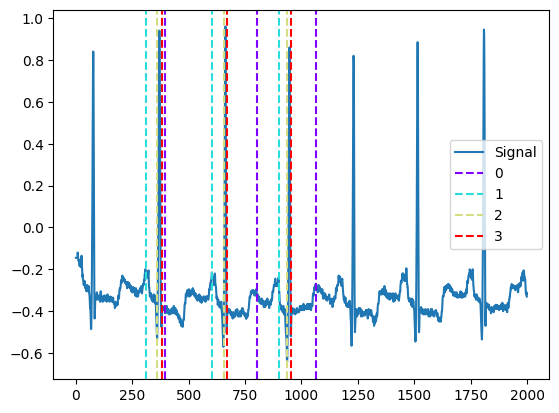

In [3]:
# Check if the database exists
dbdir = 'mit-bih-arrhythmia-database-1.0.0'
if not os.path.isdir(dbdir):
    logging.error('Please replace dbdir with the db direcotry')
    raise FileNotFoundError(dbdir)

# Load records file by file
for _ in range(100, 101):
    try:
        record = wfdb.rdrecord('{}/{}'.format(dbdir, _))
        annotation = wfdb.rdann('{}/{}'.format(dbdir, _), 'atr')
    except FileNotFoundError:
        continue

    sampling_frequency = annotation.fs
    ecg_signal = record.p_signal[:, 0]
    # Find all r peaks in a record
    _, r_peaks = nk.ecg_peaks(record.p_signal[:, 0], sampling_rate=sampling_frequency)
    # Find T_peaks, P-peaks, Q-peaks, S-peaks, P-onset and T-offset
    _, waves_peaks = nk.ecg_delineate(ecg_signal, r_peaks, sampling_rate=sampling_frequency, method="peak")
    # Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
    plot = nk.events_plot([waves_peaks['ECG_T_Peaks'][:3],
                           waves_peaks['ECG_P_Peaks'][:3],
                           waves_peaks['ECG_Q_Peaks'][:3],
                           waves_peaks['ECG_S_Peaks'][:3]], ecg_signal[:2000])


# Distribution of classes

In [ ]:
labels, values = zip(*Counter([s[0] for s in slices]).items())
plt.bar(labels, values)
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.title('Distribution of Beat and Non-beat annotations')
plt.xlabel('Annotation')
plt.ylabel('Frequency')
plt.show()

## Beat annotations
(\+)      Rhythm change

(N)       Normal beat

(A)		Atrial premature beat

(/)		Paced beat

(f)		Fusion of paced and normal beat

(~)		Change in signal quality

(V)		Premature ventricular contraction

(x)		Non-conducted P-wave (blocked APC)

(L)		Left bundle branch block beat

(R)		Right bundle branch block beat

(F)		Fusion of ventricular and normal beat

# Features for classification:
* age
* sex
* PR interval
* RT interval

# SVM Gaussian radial basis function